<a href="https://colab.research.google.com/github/MR-Toufigh/Basics-of-intelligent-systems-fall-2024/blob/main/The_second_mini_project_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# %%
# Load the California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target


             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

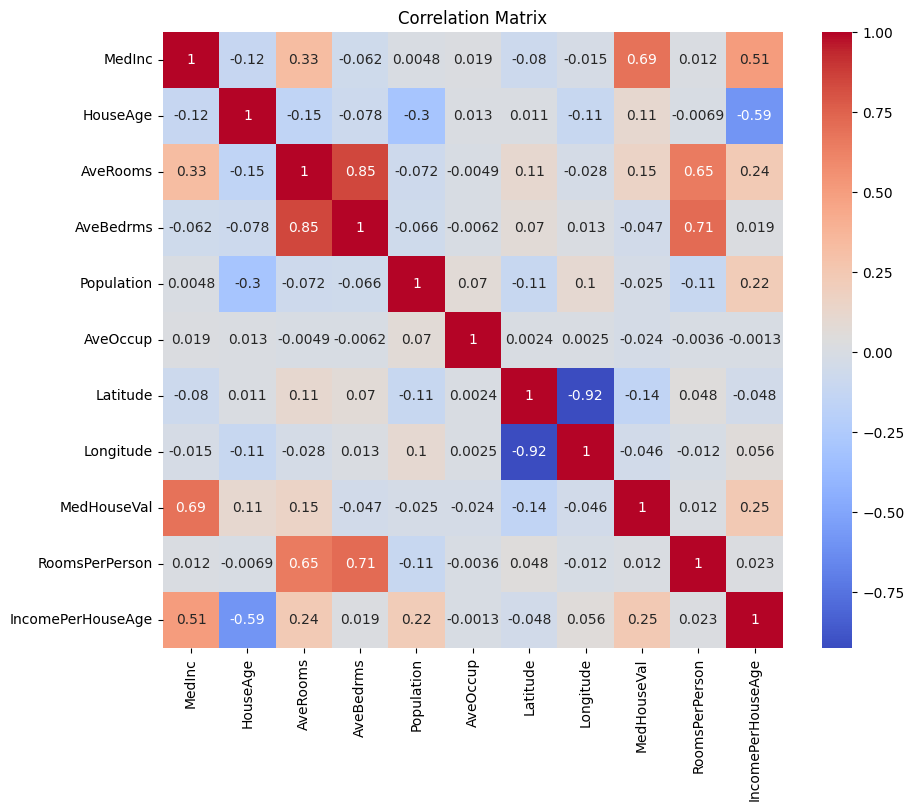

129/129 [==============================] - 0s 2ms/step
RBF Model - MSE: 0.3404280176903929, MAE: 0.4074829021906991, R^2: 0.7473991763403188
Dense Model - MSE: 0.2691294130706989, MAE: 0.3445445162400488, R^2: 0.8003034184027339


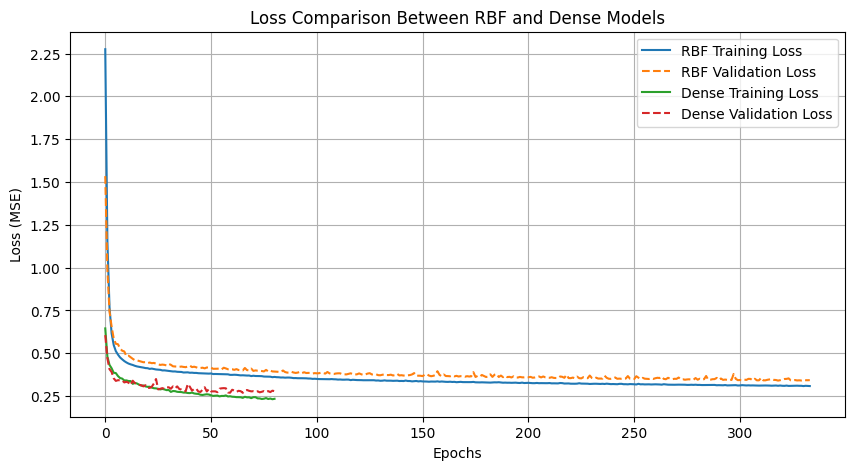

The Dense model performed better.


In [ ]:
# %%
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

# %%
# Load the California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target


# Create a DataFrame for better analysis
df = pd.DataFrame(X, columns=data.feature_names)
df['MedHouseVal'] = y


# %%
# Analyze data
print(df.describe())

# Add derived features
df['RoomsPerPerson'] = df['AveRooms'] / df['Population']
df['IncomePerHouseAge'] = df['MedInc'] / (df['HouseAge'] + 1)  # Avoid division by zero


plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Prepare features and target
X = df.drop(columns=['MedHouseVal']).values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=13)

# %%
# Define the custom RBF Layer
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.constant(gamma)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='uniform',
                                       trainable=True)
        self.log_sigma = self.add_weight(name='log_sigma',
                                         shape=(self.units,),
                                         initializer='zeros',
                                         trainable=True)
        self.built = True

    def call(self, inputs):
        diff = K.expand_dims(inputs, axis=1) - self.centers
        l2 = K.sum(K.square(diff), axis=-1)
        sigma = K.exp(self.log_sigma)
        return K.exp(-self.gamma * l2 / (2.0 * K.square(sigma)))

# %%
# Build the RBF model
rbf_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    RBFLayer(units=128, gamma=1.0),  # Improved RBF Layer with adjustable sigma
    Dense(1)
])

rbf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

rbf_history = rbf_model.fit(
    X_train, y_train, epochs=500, batch_size=32, verbose=0, validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

# %%
# Build the Dense model
dense_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mse'])

dense_history = dense_model.fit(
    X_train, y_train, epochs=500, batch_size=32, verbose=0, validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

# %%
# Evaluate both models
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

rbf_mse, rbf_mae, rbf_r2 = evaluate_model(rbf_model, X_test, y_test)
dense_mse, dense_mae, dense_r2 = evaluate_model(dense_model, X_test, y_test)

print(f"RBF Model - MSE: {rbf_mse}, MAE: {rbf_mae}, R^2: {rbf_r2}")
print(f"Dense Model - MSE: {dense_mse}, MAE: {dense_mae}, R^2: {dense_r2}")

# %%
# Visualize loss comparison
plt.figure(figsize=(10, 5))
plt.plot(rbf_history.history['loss'], label='RBF Training Loss')
plt.plot(rbf_history.history['val_loss'], label='RBF Validation Loss', linestyle='--')
plt.plot(dense_history.history['loss'], label='Dense Training Loss')
plt.plot(dense_history.history['val_loss'], label='Dense Validation Loss', linestyle='--')
plt.title('Loss Comparison Between RBF and Dense Models')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# %%
# Decision on better model
if rbf_mse < dense_mse:
    print("The RBF model performed better.")
else:
    print("The Dense model performed better.")
